In [1]:
#SET DATASET FOLDERS - these are the locations where data should be pulled FROM
dataset_exp_44_folder = 'livestalk-connolly-raw-44-h'
dataset_exp_44_45_folder = 'livestalk-connolly-raw-44_45-h'
dataset_exp_44_48_folder = 'livestalk-connolly-raw-44_48-h'
dataset_exp_carbondale_folder = 'livestalk_carbondale-raw-h'


#SET AUGMENTED FOLDER - this is the location where the dataset should be pushed TO
augmented_exp_44_folder = 'livestalk-connolly-raw-44-h-aug1'
augmented_exp_44_45_folder = 'livestalk-connolly-raw-44_45-h-aug1'
augmented_exp_44_48_folder = 'livestalk-connolly-raw-44_48-h-aug1'
augmented_exp_carbondale_folder = 'livestalk_carbondale-raw-h-aug1'

In [2]:
%matplotlib inline

import random
import os

import cv2
from PIL import Image
from matplotlib import pyplot as plt

import torch
from torch.utils.data import DataLoader, Dataset
import albumentations as A


import pandas as pd
import numpy as np
from tqdm import tqdm

# Load Data

In [3]:
class CowDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None, mode='train'):
        self.root = root
        self.transform = transform
        assert mode in ['train','valid','test'], 'invalid mode argument provided'
        self.mode = mode
        self.data_dir = root + '/' + mode 
        # load all image files, sorting them to
        # ensure that they are aligned
        self.image_files = sorted([name for name in os.listdir(self.data_dir+'/images')])
        self.label_files = sorted([name for name in os.listdir(self.data_dir+'/labels')])
        assert len(self.image_files) == len(self.label_files)
        
        self.files = [x.rsplit('.',1)[0] for x in self.image_files]


    def __getitem__(self, idx):
        
        fname = self.files[idx]
        img_path = f'{self.data_dir}/images/{fname}.jpg'
        label_path = f'{self.data_dir}/labels/{fname}.txt'        

        image = np.array(Image.open(img_path))
        
        assert image is not None, 'Image not found ' + img_path
        
        annotation_data = pd.read_csv(label_path,sep=' ',header=None,names=['class','x','y','width','height'])
        bboxes = annotation_data[['x','y','width','height']].astype(float).values
        labels = annotation_data['class'].astype(int).values        
                
        if self.transform is not None:
            augmentations = self.transform(image=image,bboxes=bboxes)
            image = augmentations['image']
            bboxes = augmentations['bboxes']
    
        
        return image, bboxes, labels, (img_path,label_path)
 

    def __len__(self):
        return len(self.files)
    
        
    
def plot_image(image,boxes,title=None):

    fig,ax=plt.subplots(figsize=(12,12))
    dh,dw,_ = image.shape
    boxes = pd.DataFrame(boxes,columns=['x','y','width','height'])
    for i,row in boxes.iterrows():
        # Taken from https://stackoverflow.com/questions/64096953/how-to-convert-yolo-format-bounding-box-coordinates-into-opencv-format
        l = int((row['x'] - row['width'] / 2) * dw)
        r = int((row['x'] + row['width'] / 2) * dw)
        t = int((row['y'] - row['height'] / 2) * dh)
        b = int((row['y'] + row['height'] / 2) * dh)

        if l < 0:
            l = 0
        if r > dw - 1:
            r = dw - 1
        if t < 0:
            t = 0
        if b > dh - 1:
            b = dh - 1

        cv2.rectangle(image, (l, t), (r, b), (0, 0, 255), 1)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.show()

    

train_transform = A.Compose(
    [
        A.Resize(height=736,width=736)
    ], bbox_params=A.BboxParams(format="yolo",min_visibility=0.5,label_fields=[])
)

valid_transform = A.Compose(
    [
        A.Resize(width=736, height=736)
    ], bbox_params=A.BboxParams(format="yolo",min_visibility=0.5,label_fields=[])
)

test_transform = A.Compose(
    [
        A.Resize(width=736, height=736)
    ], bbox_params=A.BboxParams(format="yolo",min_visibility=0.5,label_fields=[])
)


#exp1 - 44
train_dataset_exp_44 = CowDataset(dataset_exp_44_folder,transform=train_transform,mode='train')
valid_dataset_exp_44 = CowDataset(dataset_exp_44_folder,transform=valid_transform,mode='valid')
test_dataset_exp_44 = CowDataset(dataset_exp_44_folder,transform=test_transform,mode='test')
#exp1 - 44-45
train_dataset_exp_44_45 = CowDataset(dataset_exp_44_45_folder,transform=train_transform,mode='train')
valid_dataset_exp_44_45 = CowDataset(dataset_exp_44_45_folder,transform=valid_transform,mode='valid')
test_dataset_exp_44_45 = CowDataset(dataset_exp_44_45_folder,transform=test_transform,mode='test')
#exp1 - 44-48
train_dataset_exp_44_48 = CowDataset(dataset_exp_44_48_folder,transform=train_transform,mode='train')
valid_dataset_exp_44_48 = CowDataset(dataset_exp_44_48_folder,transform=valid_transform,mode='valid')
test_dataset_exp_44_48 = CowDataset(dataset_exp_44_48_folder,transform=test_transform,mode='test')
#exp1 - Carbondale
train_dataset_exp_carbondale = CowDataset(dataset_exp_carbondale_folder,transform=train_transform,mode='train')
valid_dataset_exp_carbondale = CowDataset(dataset_exp_carbondale_folder,transform=valid_transform,mode='valid')
test_dataset_exp_carbondale = CowDataset(dataset_exp_carbondale_folder,transform=test_transform,mode='test')



# Visualize Augmented Images

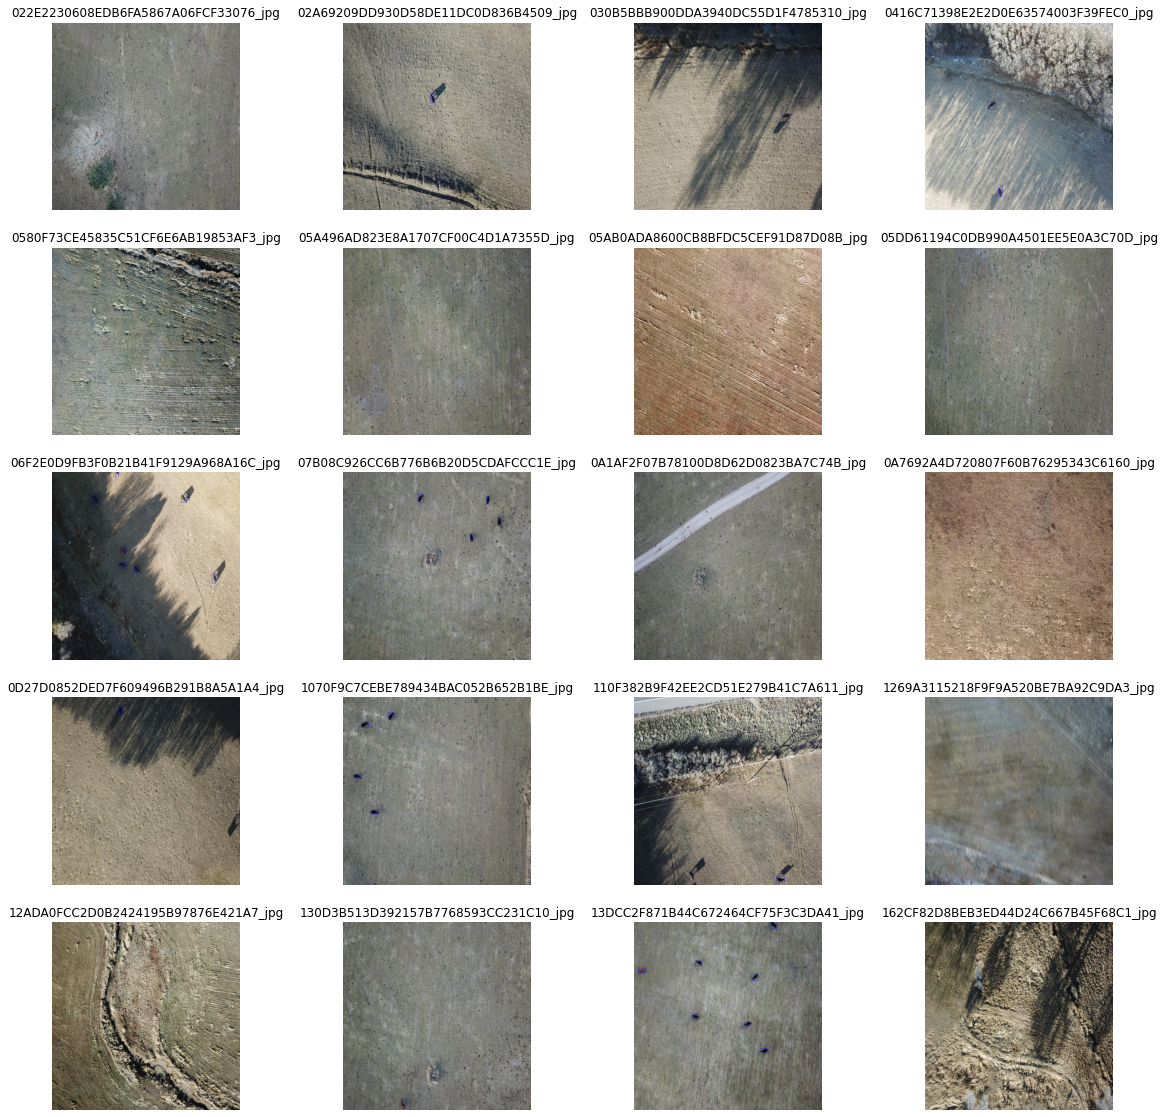

In [4]:
def plot_examples(dataset):
    fig = plt.figure(figsize=(20, 20))
    columns = 4
    rows = 5

    for j in range(1, 21):
        img,boxes,labels,_ = dataset[j-1]
        
        dh,dw,_ = img.shape
        boxes = pd.DataFrame(boxes,columns=['x','y','width','height'])
        for i,row in boxes.iterrows():
            # Taken from https://stackoverflow.com/questions/64096953/how-to-convert-yolo-format-bounding-box-coordinates-into-opencv-format
            l = int((row['x'] - row['width'] / 2) * dw)
            r = int((row['x'] + row['width'] / 2) * dw)
            t = int((row['y'] - row['height'] / 2) * dh)
            b = int((row['y'] + row['height'] / 2) * dh)

            if l < 0:
                l = 0
            if r > dw - 1:
                r = dw - 1
            if t < 0:
                t = 0
            if b > dh - 1:
                b = dh - 1

            cv2.rectangle(img, (l, t), (r, b), (0, 0, 255), 1)
        fig.add_subplot(rows, columns, j)
        plt.imshow(img)
        plt.axis('off')
        plt.title(dataset.files[j-1].split('.',1)[0])
    plt.show()
    
plot_examples(train_dataset_exp_carbondale)

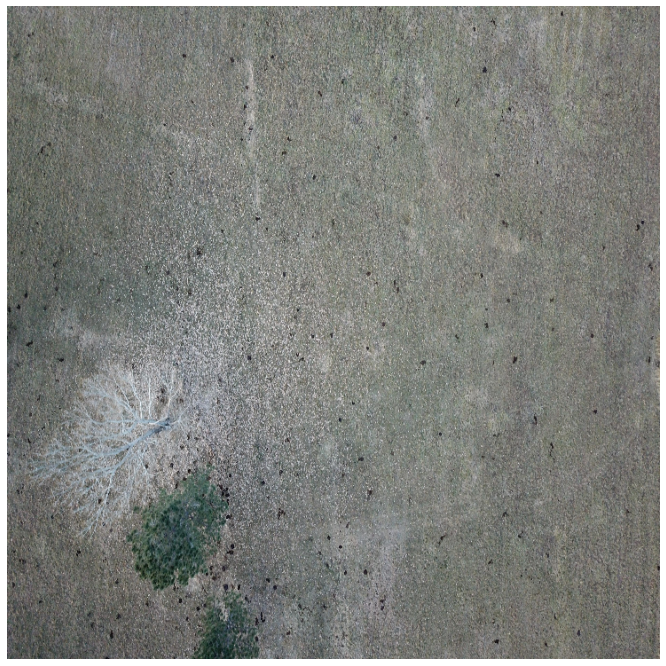

In [5]:
img,boxes,labels,_ = train_dataset_exp_carbondale[0] #enter index here to see different outputs
plot_image(img,boxes)

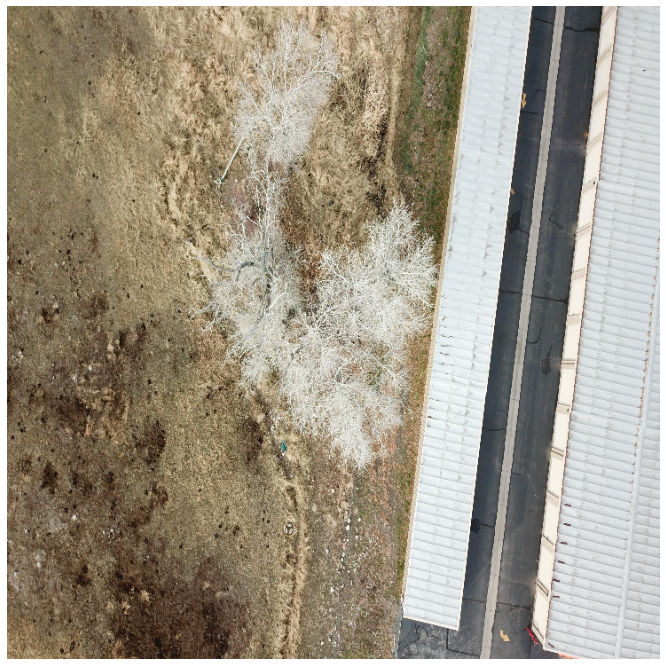

In [6]:
img,boxes,labels,_ = valid_dataset_exp_carbondale[5] #enter index here to see different outputs
plot_image(img,boxes)

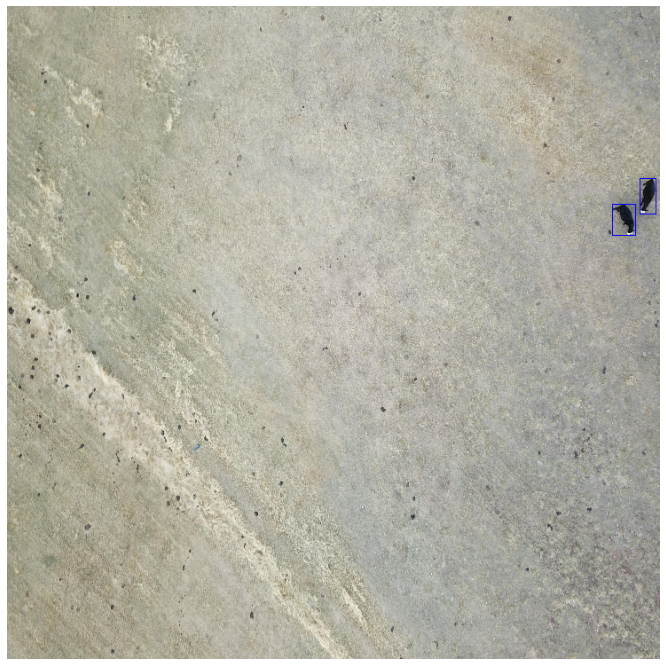

In [7]:
img,boxes,labels,_ = test_dataset_exp_carbondale[20] #enter index here to see different outputs
plot_image(img,boxes)

# Save dataset

In [9]:
augmented_exp_44_folder = 'livestalk-connolly-raw-44-h-aug1'
augmented_exp_44_45_folder = 'livestalk-connolly-raw-44_45-h-aug1'
augmented_exp_44_48_folder = 'livestalk-connolly-raw-44_48-h-aug1'
augmented_exp_carbondale_folder = 'livestalk_carbondale-raw-h-aug1'


def save_dataset(augmented_folder,train_dataset,valid_dataset,test_dataset):
    augmented_path = os.path.join(os.getcwd(),augmented_folder)
    assert not os.path.exists(augmented_path), 'folder already exists'
    os.mkdir(f'{augmented_path}')
    os.mkdir(f'{augmented_path}/train')
    os.mkdir(f'{augmented_folder}/train/images')
    os.mkdir(f'{augmented_folder}/train/labels')
    os.mkdir(f'{augmented_folder}/valid')
    os.mkdir(f'{augmented_folder}/valid/images')
    os.mkdir(f'{augmented_folder}/valid/labels')
    os.mkdir(f'{augmented_folder}/test')
    os.mkdir(f'{augmented_folder}/test/images')
    os.mkdir(f'{augmented_folder}/test/labels')

    #create data.yaml
    yaml_txt = """names:
- cow
nc: 1
train: {0}/train/images
val: {0}/valid/images
test: {0}/test/images
""".format(augmented_path)

    with open(os.path.join(augmented_path,'data.yaml'),'w') as f:
        f.write(yaml_txt)

    #save data
    def save_data(dataset):
        with tqdm(total=len(dataset),desc='Saving {} data'.format(dataset.mode)) as pbar:
            for i, data in enumerate(dataset):
                image,bboxes,label,filepaths = data
                image_path = filepaths[0]
                label_path = filepaths[1]

                aug_image_path = os.path.join(augmented_path,dataset.mode,'images','AUG_'+image_path.rsplit('/',1)[1])
                aug_label_path = os.path.join(augmented_path,dataset.mode,'labels','AUG_'+label_path.rsplit('/',1)[1])

                im = Image.fromarray(image)
                im.save(aug_image_path)

                target = pd.DataFrame(bboxes,columns=['x','y','width','height'])
                target['class'] = 0
                target = target[['class','x','y','width','height']]
                target.to_csv(aug_label_path,sep=' ',header=False,index=False)
                pbar.update(1)
    
    save_data(train_dataset)
    save_data(valid_dataset)
    save_data(test_dataset)
    
print('saving data for exp 44...')
save_dataset(augmented_exp_44_folder,train_dataset_exp_44,valid_dataset_exp_44,test_dataset_exp_44)
print('\nsaving data for exp 44-45...')
save_dataset(augmented_exp_44_45_folder,train_dataset_exp_44_45,valid_dataset_exp_44_45,test_dataset_exp_44_45)
print('\nsaving data for exp 44-48...')
save_dataset(augmented_exp_44_48_folder,train_dataset_exp_44_48,valid_dataset_exp_44_48,test_dataset_exp_44_48)
print('\nsaving data for exp carbondale...')
save_dataset(augmented_exp_carbondale_folder,train_dataset_exp_carbondale,valid_dataset_exp_carbondale,test_dataset_exp_carbondale)
    

saving data for exp 44...


Saving test data: 100%|█████████████████████████| 59/59 [00:07<00:00,  7.49it/s]



saving data for exp 44-45...


Saving test data: 100%|█████████████████████████| 59/59 [00:07<00:00,  7.51it/s]



saving data for exp 44-48...


Saving test data: 100%|█████████████████████████| 59/59 [00:07<00:00,  7.49it/s]



saving data for exp carbondale...


Saving test data: 100%|█████████████████████████| 59/59 [00:07<00:00,  7.65it/s]
